<a href="https://colab.research.google.com/github/MOOWOO/fastfood-classification/blob/main/convnext_fastfood_classification_skeleton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Set up Environment & Prepare the Dataset

In [1]:
# Set up Environment & Prepare the Dataset
!pip install torch torchvision torchaudio transformers

In [2]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from PIL import Image
from transformers import ConvNextForImageClassification, ConvNextImageProcessor
from torchvision import transforms
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
import zipfile
from google.colab import drive
import torch.optim as optim
import torch.nn.functional as F
%matplotlib inline

In [3]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Mount Google Drive
drive.mount('/content/drive')

Using device: cuda
Mounted at /content/drive


In [4]:
# Define utility functions
def extract_zip(filename, input_path, output_base_path):
    output_path = os.path.join(output_base_path, filename)
    os.makedirs(output_path, exist_ok=True)
    with zipfile.ZipFile(input_path, 'r') as zip_file:
        zip_file.extractall(output_path)
    print(f"Extracted {filename}.zip to {output_path}.")

def get_classes_for_dataset(filename, base_path):
    data_path = os.path.join(base_path, filename)
    classes = sorted(os.listdir(data_path))
    classes_dict = {i: item for i, item in enumerate(classes)}
    classes_rev = {value: key for key, value in classes_dict.items()}
    return classes_dict, classes_rev

In [5]:
# Dataset paths
source_path = '/content/drive/MyDrive/fastfood'
target_base_path = './data'
train_filename = "Train"
test_filename = "Test"

# Extract Train and Test datasets
extract_zip(train_filename, os.path.join(source_path, train_filename + ".zip"), target_base_path)
extract_zip(test_filename, os.path.join(source_path, test_filename + ".zip"), target_base_path)

# Load classes and map them
train_classes, train_classes_rev = get_classes_for_dataset(train_filename, target_base_path)


Extracted Train.zip to ./data/Train.
Extracted Test.zip to ./data/Test.


In [6]:
# Preprocess the dataset
def preprocess_data(data_dir, class_rev, image_size=(224, 224)):
    data, labels = [], []
    for class_name, class_idx in class_rev.items():
        img_dir = os.path.join(data_dir, class_name)
        for image_name in os.listdir(img_dir):
            img = Image.open(os.path.join(img_dir, image_name)).convert("RGB").resize(image_size)
            data.append(np.array(img).astype('float32') / 255)
            labels.append(class_idx)
    return np.array(data), np.array(labels)


In [7]:
data, labels = preprocess_data(os.path.join(target_base_path, train_filename), train_classes_rev)


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [8]:
# **Plot class distribution**
def plot_class_distribution(labels, class_mapping):
    train_label_str = [key for label_int in labels.tolist() for key, value in class_mapping.items() if value == label_int]
    df_train_label = pd.DataFrame(train_label_str, columns=['label'])
    plt.figure(figsize=(10, 6))
    ax = sns.countplot(x='label', data=df_train_label, order=list(class_mapping.keys()))
    ax.set_title('Train Label Distribution')
    plt.xticks(rotation=45, ha="right")
    plt.show()

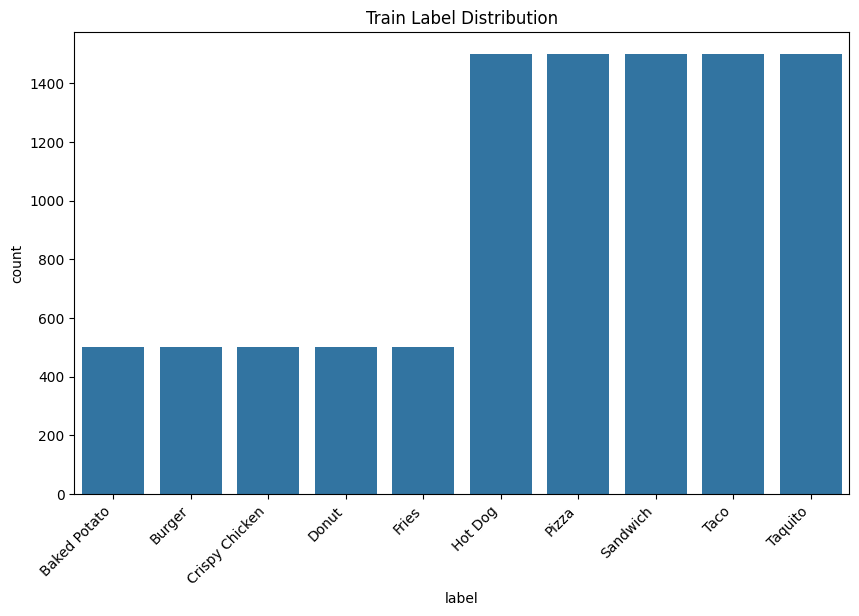

In [9]:
# Call plot function to visualize label distribution
plot_class_distribution(labels, train_classes_rev)

In [10]:
# Data augmentation using ImageDataGenerator
def augment_data(X_train, y_train):
    # Ensure the input data has the right dimensions (batch_size, height, width, channels)
    if X_train.ndim == 3:
        X_train = np.expand_dims(X_train, axis=-1)  # If the data is missing the channel dimension, add it

    generator = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        zoom_range=0.2,
        shear_range=0.1,
    )

    # Fit the generator to the data
    generator.fit(X_train)

    # Augment the data (retain the 4D shape: batch, height, width, channels)
    aug1 = next(generator.flow(X_train, batch_size=len(X_train), shuffle=False))
    aug2 = next(generator.flow(X_train, batch_size=len(X_train), shuffle=False))

    # Concatenate the original and augmented data
    X_train_aug = np.concatenate((X_train, aug1, aug2))
    y_train_aug = np.concatenate((y_train, y_train, y_train))

    return X_train_aug, y_train_aug

In [11]:
def augment_class_data(X_train, y_train, class_name, class_rev, augmentation_factor=2):
    class_idx = class_rev[class_name]
    class_data = X_train[y_train == class_idx]
    class_labels = y_train[y_train == class_idx]

    augmented_data = np.concatenate([class_data for _ in range(augmentation_factor)], axis=0)
    augmented_labels = np.array([class_idx] * augmented_data.shape[0])

    return np.concatenate([X_train, augmented_data], axis=0), np.concatenate([y_train, augmented_labels], axis=0)

In [12]:
# MixUp 적용
def mixup_data(x, y, alpha=0.2):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.shape[0]
    index = np.random.permutation(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

In [13]:
def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)


In [14]:
# Augment training data with MixUp
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
X_train, y_train = augment_data(X_train, y_train)



In [15]:
X_train, y_train = augment_class_data(X_train, y_train, 'Baked Potato', train_classes_rev, augmentation_factor=2)
X_train, y_train = augment_class_data(X_train, y_train, 'Burger', train_classes_rev, augmentation_factor=2)
X_train, y_train = augment_class_data(X_train, y_train, 'Crispy Chicken', train_classes_rev, augmentation_factor=2)
X_train, y_train = augment_class_data(X_train, y_train, 'Donut', train_classes_rev, augmentation_factor=2)
X_train, y_train = augment_class_data(X_train, y_train, 'Fries', train_classes_rev, augmentation_factor=2)

In [16]:
# Compute class weights
class_weight = compute_class_weight(class_weight="balanced", classes=np.unique(labels), y=labels)
class_weight = {i: class_weight[i] for i in range(len(np.unique(labels)))}


In [17]:
# Self-Attention Layer 정의
class SelfAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(SelfAttention, self).__init__()
        self.query = nn.Linear(input_dim, hidden_dim)
        self.key = nn.Linear(input_dim, hidden_dim)
        self.value = nn.Linear(input_dim, hidden_dim)
        self.hidden_dim = hidden_dim

    def forward(self, x):
        # x should have shape (batch_size, seq_len, input_dim)
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)

        # Attention matrix (batch_size, seq_len, seq_len)
        attention_scores = torch.softmax(torch.bmm(Q, K.transpose(1, 2)) / (self.hidden_dim ** 0.5), dim=-1)
        attention_output = torch.bmm(attention_scores, V)

        return attention_output

# ConvNeXt 모델 확장 (pre-trained ConvNeXt에 Self-Attention 추가)
class ConvNextWithAttention(nn.Module):
    def __init__(self, num_classes):
        super(ConvNextWithAttention, self).__init__()
        self.convnext = ConvNextForImageClassification.from_pretrained(
            'facebook/convnext-tiny-224',
            num_labels=num_classes,
            ignore_mismatched_sizes=True
        )

        # ConvNeXt의 feature dimension 가져옴
        convnext_output_dim = self.convnext.classifier.in_features

        # Self-Attention Layer 추가
        hidden_dim = convnext_output_dim  # Self-Attention의 hidden_dim을 convnext_output_dim으로 설정
        self.attention = SelfAttention(convnext_output_dim, hidden_dim)

        # Fully connected layer (Classifier)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        # ConvNeXt의 피처 추출 부분 (batch_size, channels, height, width)
        output = self.convnext.convnext(x)  # ConvNeXt 출력은 BaseModelOutputWithPoolingAndNoAttention 객체

        # ConvNeXt의 last_hidden_state 가져오기 (batch_size, channels, height, width)
        x = output.last_hidden_state

        # x의 차원을 (batch_size, seq_len, feature_dim)으로 변환
        batch_size, feature_dim, height, width = x.shape
        seq_len = height * width  # seq_len으로 height와 width를 곱함
        x = x.view(batch_size, feature_dim, seq_len).permute(0, 2, 1)  # (batch_size, seq_len, feature_dim)

        # Self-Attention 적용
        x = self.attention(x)

        # Global Average Pooling (batch_size, hidden_dim)
        x = torch.mean(x, dim=1)

        # Fully connected layer (Classifier)
        x = self.fc(x)

        return x

# 모델 인스턴스 생성 및 장치로 이동
num_classes = len(np.unique(labels))  # 데이터셋에서 고유 클래스 개수
model = ConvNextWithAttention(num_classes).to(device)

# 이미지 프로세서 로드
image_processor = ConvNextImageProcessor.from_pretrained('facebook/convnext-tiny-224')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/69.6k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/114M [00:00<?, ?B/s]

Some weights of ConvNextForImageClassification were not initialized from the model checkpoint at facebook/convnext-tiny-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preprocessor_config.json:   0%|          | 0.00/266 [00:00<?, ?B/s]

In [18]:
# ConvNeXT 모델의 모든 파라미터의 requires_grad를 False로 설정
for param in model.convnext.parameters():
    param.requires_grad = False

# Self-Attention 레이어와 Classifier 레이어만 학습 가능하게 설정
for param in model.attention.parameters():  # Self-Attention 레이어 파라미터
    param.requires_grad = True

for param in model.fc.parameters():  # Classifier 부분 파라미터
    param.requires_grad = True

In [19]:
# Define data transforms
def get_transform(is_train=True):
    if is_train:
        return transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
        ])
    else:
        return transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
        ])


In [20]:
# Prepare dataset and DataLoader
def prepare_data_loaders(X_train, y_train, batch_size=64):
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).permute(0, 3, 1, 2)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    return train_loader, val_loader

In [21]:
train_loader, val_loader = prepare_data_loaders(X_train, y_train)

In [32]:
# Define the Early Stopping class
class EarlyStopping:
    def __init__(self, patience=5, delta=0.001):
        self.patience = patience  # 몇 번의 에포크 동안 개선이 없으면 중단
        self.delta = delta  # 개선이라고 판단할 최소한의 변화량
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None or val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [33]:
# Training and validation functions with logging, regularization, and early stopping
def train_model_with_logging(model, train_loader, val_loader, epochs=1000, lr=1e-4, mixup_alpha=0.2, weight_decay=1e-4):
    # Weight decay adds L2 regularization
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()

    # Early stopping setup
    early_stopping = EarlyStopping(patience=5, delta=0.001)

    # 기록 저장용 리스트
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        correct_train = 0
        total_train = 0

        for data, target in train_loader:
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()

            # Apply MixUp
            mixed_data, y_a, y_b, lam = mixup_data(data, target, alpha=mixup_alpha)
            mixed_data, y_a, y_b = mixed_data.to(device), y_a.to(device), y_b.to(device)

            # ConvNeXt 출력이 Tensor로 나오므로 .logits 참조를 제거
            output = model(mixed_data)

            loss = mixup_criterion(criterion, output, y_a, y_b, lam)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(output, 1)
            correct_train += (predicted == y_a).sum().item()
            total_train += y_a.size(0)

        # 학습 손실 및 정확도 기록
        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {train_loss:.4f}, Accuracy: {train_acc:.2f}%")

        # 검증 손실 및 정확도 기록
        val_loss, val_acc = validate_model(model, val_loader, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")

        # Early Stopping 체크
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print(f"Early stopping at epoch {epoch + 1}")
            break

    return train_losses, val_losses, train_accuracies, val_accuracies


In [34]:
def validate_model(model, val_loader, criterion):
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            val_loss += loss.item()
            _, predicted = torch.max(output, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    val_loss /= len(val_loader)
    val_acc = 100. * correct / total
    return val_loss, val_acc


In [35]:
# Train the model and capture losses and accuracies + mixup
train_losses, val_losses, train_accuracies, val_accuracies = train_model_with_logging(model, train_loader, val_loader)


Epoch [1/1000], Loss: 0.5295, Accuracy: 51.60%
Validation Loss: 0.2645, Validation Accuracy: 92.86%
Epoch [2/1000], Loss: 0.5246, Accuracy: 52.24%
Validation Loss: 0.2589, Validation Accuracy: 92.74%
Epoch [3/1000], Loss: 0.5856, Accuracy: 54.55%
Validation Loss: 0.2624, Validation Accuracy: 92.99%
Epoch [4/1000], Loss: 0.5472, Accuracy: 55.10%
Validation Loss: 0.2603, Validation Accuracy: 92.70%
Epoch [5/1000], Loss: 0.5488, Accuracy: 53.63%
Validation Loss: 0.2690, Validation Accuracy: 92.74%
Epoch [6/1000], Loss: 0.6288, Accuracy: 51.19%
Validation Loss: 0.2680, Validation Accuracy: 93.03%
Epoch [7/1000], Loss: 0.5571, Accuracy: 54.62%
Validation Loss: 0.2672, Validation Accuracy: 92.61%
Early stopping at epoch 7


In [36]:
# Plotting the training and validation loss
def plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(14, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
    plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_accuracies, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.show()


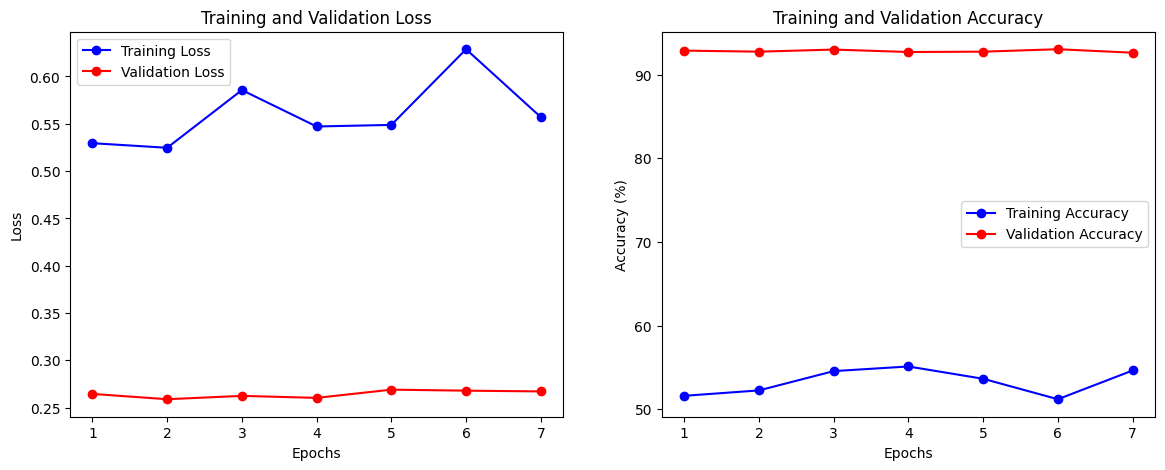

In [37]:
# Call the function to plot the results
plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies)


In [40]:
import torch.nn.functional as F

# Predict and save results with probabilities
def predict_and_save(test_dir, model, transform, output_csv='result_with_probs.csv'):
    model.eval()
    test_images = [f for f in os.listdir(test_dir) if f.endswith('.jpg')]
    results = []
    with torch.no_grad():
        for img_name in test_images:
            img_path = os.path.join(test_dir, img_name)
            image = Image.open(img_path).convert("RGB")
            image = transform(image).unsqueeze(0).to(device)
            output = model(image)  # Model output (logits)

            # Apply Softmax to get probabilities
            probabilities = F.softmax(output, dim=1)  # Convert logits to probabilities

            # Get the predicted label and its probability
            predicted_label = torch.argmax(probabilities, dim=1).item()
            predicted_prob = torch.max(probabilities).item()  # Get the highest probability

            # Append result with probability
            results.append({
                "Image": img_name,
                "Class": predicted_label,
                "Probability": predicted_prob
            })

    # Save results to CSV
    pd.DataFrame(results).to_csv(output_csv, index=False)
    print(f"Results with probabilities saved to {output_csv}")

# Predict and save test results with probabilities
test_dir = '/content/data/Test'
predict_and_save(test_dir, model, get_transform(is_train=False))


Results with probabilities saved to result_with_probs.csv


In [39]:
# Predict and save test results
test_dir = '/content/data/Test'
predict_and_save(test_dir, model, get_transform(is_train=False))

Results saved to result.csv
